### Load datasets

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape, y.shape

((70000, 784), (70000,))

### Visualize

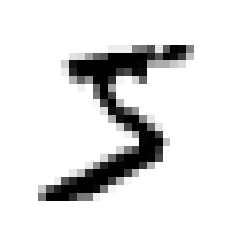

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [5]:
y[0]

'5'

In [6]:
import numpy as np

y = y.astype(np.uint8)

In [7]:
idx = 60000

X_train, X_test, y_train, y_test = X[:idx], X[idx:], y[:idx], y[idx:]

In [8]:
y_train.shape

(60000,)

### Binary "is five?" classifier

In [9]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=93)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=93, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [11]:
sgd_clf.predict([some_digit])

array([ True])

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=4)

array([0.96505, 0.9677 , 0.96105])

### Are those results good?

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy', n_jobs=4)

array([0.91125, 0.90855, 0.90915])

above 90% wich always not-five - because data is highly skewed, so sgd results aren't so good either

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, n_jobs=4)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53829,   750],
       [ 1374,  4047]])

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Use precision and recall

In [17]:
from sklearn.metrics import precision_score, recall_score

print('precision: ',precision_score(y_train_5, y_train_pred))
print('recall: ', recall_score(y_train_5, y_train_pred))

precision:  0.8436522826766729
recall:  0.746541228555617


f1 combines precision and recall - and it's high only when both precision and recall are high

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7921315325895477

In [19]:
y_scores = sgd_clf.decision_function([some_digit])

In [20]:
y_scores

array([1502.06399196])

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function', n_jobs=4)

In [23]:
y_scores[:10]

array([  3118.03825825, -19286.16206207, -33297.66242706, -13311.7897362 ,
       -13836.19324214, -15864.11971038, -13504.54227111, -14462.33342905,
        -6030.51851381,  -8949.29237208])

#### Precision, recall on threshold

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

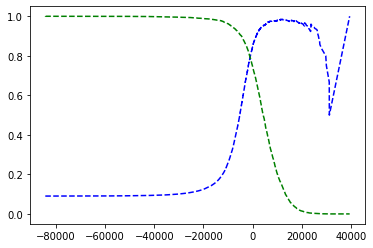

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall')
    plt.show()

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

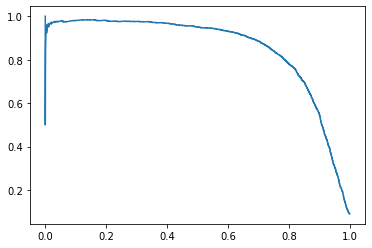

In [26]:
plt.plot(recalls[:-1], precisions[:-1], label='precision')

In [27]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9000738370662072

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.6745987825124515

### ROC (Receiver Operating Characteristic) curve
True Positive Rate (TPR, Sensitivity) vs False Positive Rate(FPR)
FPR = 1 - TNR (True Negative Rate, Specificity)

When class is rare or False Positives are more important than False Negatives -> Precision / Recall curve

In [30]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

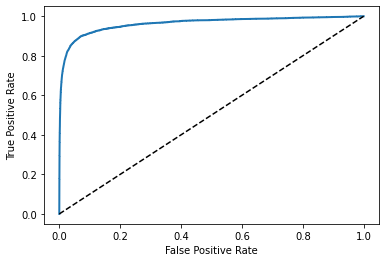

In [31]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9626104071311276

here we can see that 0.96 roc auc is nice - but class is rare so...

### Compare this SGD roc with Random Forest

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba', n_jobs=4)

In [34]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

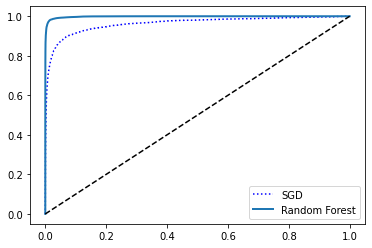

In [35]:
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [37]:
forest_precisions, forest_recalls, forest_thresholds = precision_recall_curve(y_train_5, y_scores_forest)

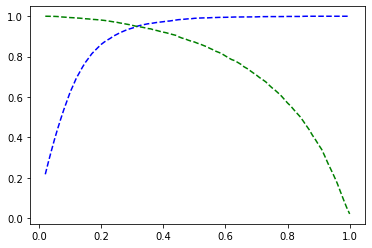

In [38]:
plot_precision_recall_vs_threshold(forest_precisions, forest_recalls, forest_thresholds)

In [39]:
thresh = 0.5
print('refall: ', recall_score(y_train_5, y_scores_forest > thresh))
print('precision: ', precision_score(y_train_5, y_scores_forest > thresh))

refall:  0.8662608374838591
precision:  0.9905083315756169


### Multiclass Classification

In [40]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=93)

svm_clf.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=93, shrinking=True, tol=0.001,
    verbose=False)

In [41]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [43]:
svm_clf

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=93, shrinking=True, tol=0.001,
    verbose=False)

In [44]:
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42), n_jobs=4)
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                  class_weight=None, coef0=0.0,
                                  decision_function_shape='ovr', degree=3,
                                  gamma='auto', kernel='rbf', max_iter=-1,
                                  probability=False, random_state=42,
                                  shrinking=True, tol=0.001, verbose=False),
                    n_jobs=4)

In [47]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
len(ovr_clf.estimators_)

10

### For SGD and Random Forest we don't need OVR - they support multiclass

In [49]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=93, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [50]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [51]:
sgd_clf.decision_function([some_digit])

array([[-21409.48505632, -43386.74213369,  -7731.69483393,
          3808.01475577, -26323.51731847,   3786.16269477,
        -23196.24163408, -13230.61186086, -13927.70744276,
         -7673.20602185]])

In [52]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy', n_jobs=4)

array([0.856 , 0.8744, 0.8851])

### Scaling the inputs improves accuracy

In [53]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [54]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy', n_jobs=4)

array([0.89905, 0.89315, 0.90185])

In [55]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3, n_jobs=4)

In [56]:
y_train_pred

array([3, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [57]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5572,    0,   21,    5,    8,   49,   36,    6,  225,    1],
       [   0, 6399,   37,   24,    4,   44,    4,    7,  210,   13],
       [  28,   26, 5235,   90,   71,   27,   67,   38,  365,   11],
       [  23,   17,  117, 5224,    2,  212,   27,   40,  397,   72],
       [  10,   14,   45,    9, 5200,   12,   35,   26,  324,  167],
       [  25,   15,   29,  166,   55, 4460,   75,   15,  517,   64],
       [  29,   16,   43,    2,   44,   98, 5550,    4,  131,    1],
       [  19,   10,   51,   26,   49,   14,    3, 5687,  186,  220],
       [  16,   65,   49,   85,    3,  129,   25,   10, 5423,   46],
       [  22,   18,   30,   64,  117,   36,    1,  179,  351, 5131]])

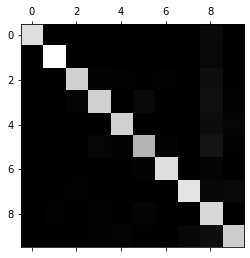

In [58]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

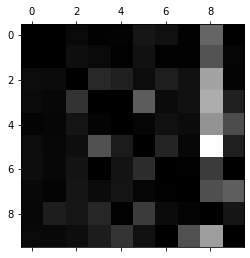

In [59]:
# normalize confusion matrix
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

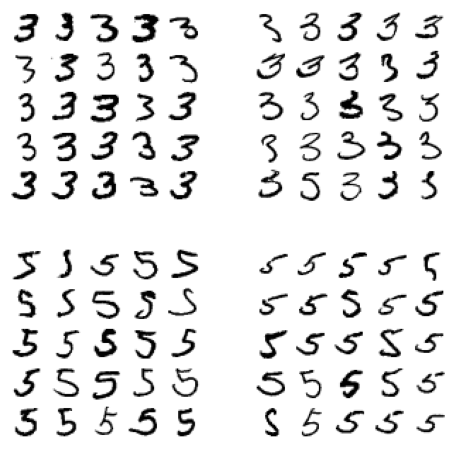

In [61]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

### Multilabel Classification

In [62]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [63]:
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [64]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [65]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=4)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

In [66]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted')

0.9778357403921755

### Multioutput Classification

In [68]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

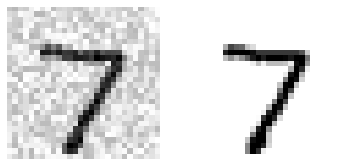

In [76]:
some_index = 0
plt.subplot(121); plot_digits([X_test_mod[some_index]])
plt.subplot(122); plot_digits([y_test_mod[some_index]])
plt.show()

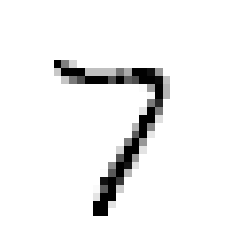

In [71]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digits(clean_digit)